In [2]:
from uuid import uuid4
class comp_node:
    def __init__(self, val, children = [] ,grad=0, op = "assign" ):
        self.val = val
        self.children = children
        self.grad = 0 #because we add, if multiply it's 1
        self.op = op
        self.backward_prop = lambda: None
        self.identity = uuid4()
    
    def __to_comp_node(self, obj):
        if not isinstance(obj , comp_node):
            return comp_node(val = obj)
        else:
            return obj
            
    def __sub__(self, other):
        other = self.__to_comp_node(other)
        out = comp_node(val = self.val - other.val , children = [self,other] , op="sub")
        def _backward_prop():
            self.grad += out.grad * 1
            other.grad += out.grad * -1
        out.backward_prop = _backward_prop
        return out
    
    def __rsub__(self,other):
        other = self.__to_comp_node(other)
        return other - self # I already defined sub
    
    def __add__(self, other):
        other = self.__to_comp_node(other)
        out = comp_node(val = self.val + other.val , children = [self,other] , op="add")
        def _backward_prop():
            self.grad += out.grad * 1
            other.grad += out.grad * 1
        out.backward_prop = _backward_prop

        return out
    
    def __radd__(self,other):
        other = self.__to_comp_node(other)
        
        return other + self # I already defined add
    
    def __mul__(self, other):
        other = self.__to_comp_node(other)
        out = comp_node(val = self.val * other.val , children = [self,other] , op="mul")
        def _backward_prop():
            self.grad += out.grad * other.val
            other.grad += out.grad * self.val
        out.backward_prop = _backward_prop

        return out
    
    def __rmul__(self,other):
        other = self.__to_comp_node(other)
        return other * self # I already defined sub
    
    
    def __pow__(self, exponent):
        if not (exponent , (int , float)):
            raise ValueError("unsupported types")
        out = comp_node(val = self.val**exponent , children = [self] , op="pow") #best place to calc grad
        
        def _backward_prop():
            self.grad += out.grad *(exponent * self.val**(exponent -1))
        out.backward_prop = _backward_prop
        return out 
    
    def __truediv__(self, other):
        other = self.__to_comp_node(other)
        if other.val == 0:
            raise ValueError("can't divide by zero")
        out = comp_node(val = self.val/other.val , children = [self,other] , op = "mul")
        return out
    
    def __eq__(self , other):
        return self.val == other.val
    
    def __repr__(self):
        
        return f"op: {self.op} | val: {self.val :.4f} | children: {len(self.children)} | grad: {self.grad}"
    
    def __hash__(self):
        return int(self.identity)
    def topo_sort(self):
        res = []
        visited = set()
        def visit(node):
            if node in visited:
                return
            else:
                visited.add(node)
                for child in node.children:
                    visit(child)
                res.append(node)
        visit(self)
        return res
    def backward(self):
        self.grad =1
        nodes = self.topo_sort()
        for (i , node) in enumerate(reversed(nodes)):
            node.backward_prop()
        


first problem: find a point in R2 with the least average eculidean distance

In [2]:
from random import Random
SEED = 5
random_gen = Random(x =SEED)

def generate_points(n = 1000):
    list_x, list_y = [], []
    for _ in range(n):
        list_x.append(random_gen.uniform(a=0 , b=1))
    for _ in range(n):
        list_y.append(random_gen.uniform(a=0 , b=1))
    return list_x , list_y
data_x ,data_y = generate_points()


C:\Windows\Temp\ipykernel_10332\3216276025.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


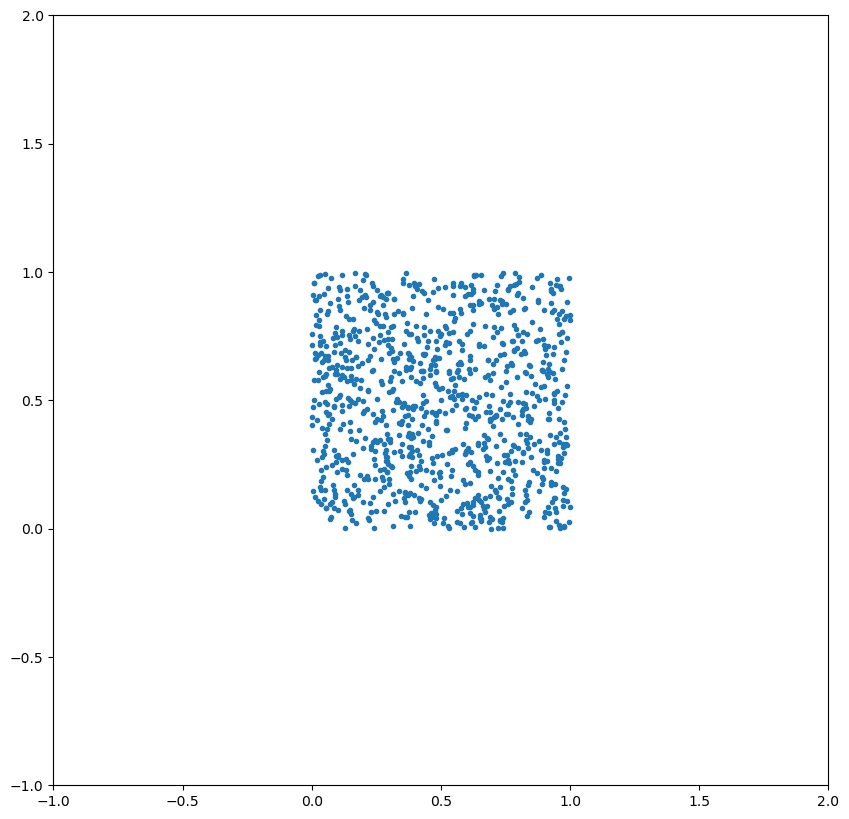

In [3]:
from matplotlib.pyplot import figure
fig = figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x = data_x,y = data_y, marker = ".")
ax.set_xlim(-1 , 2)
ax.set_ylim(-1 , 2)
fig.show()

In [4]:
x_p , y_p = comp_node(val =0.3) , comp_node(val =0.3)

def loss_graph(x_p,y_p , x, y):
    loss = 0 
    I_x , I_y = x_p - x , y_p - y
    g_x , g_y = I_x**2 , I_y**2
    M = g_x + g_y
    l = M ** (0.5)
    return l

curr_loss = loss_graph(x_p , y_p , data_x[0],data_y[0])
curr_loss.backward()


In [5]:
from pprint import pprint
x_p , y_p = comp_node(val =0.3) , comp_node(val =0.3)
def loss_graph(x_p,y_p , data_x, data_y):
    loss = 0 
    for x , y in zip(data_x , data_y):
        I_x , I_y = x_p - x , y_p - y
        g_x , g_y = I_x**2 , I_y**2
        M = g_x + g_y
        l = M ** (0.5)
        loss+= l
    return (1/len(data_x))* loss

curr_loss = loss_graph(x_p , y_p , data_x,data_y)
curr_loss.backward()


C:\Windows\Temp\ipykernel_17228\1104980524.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


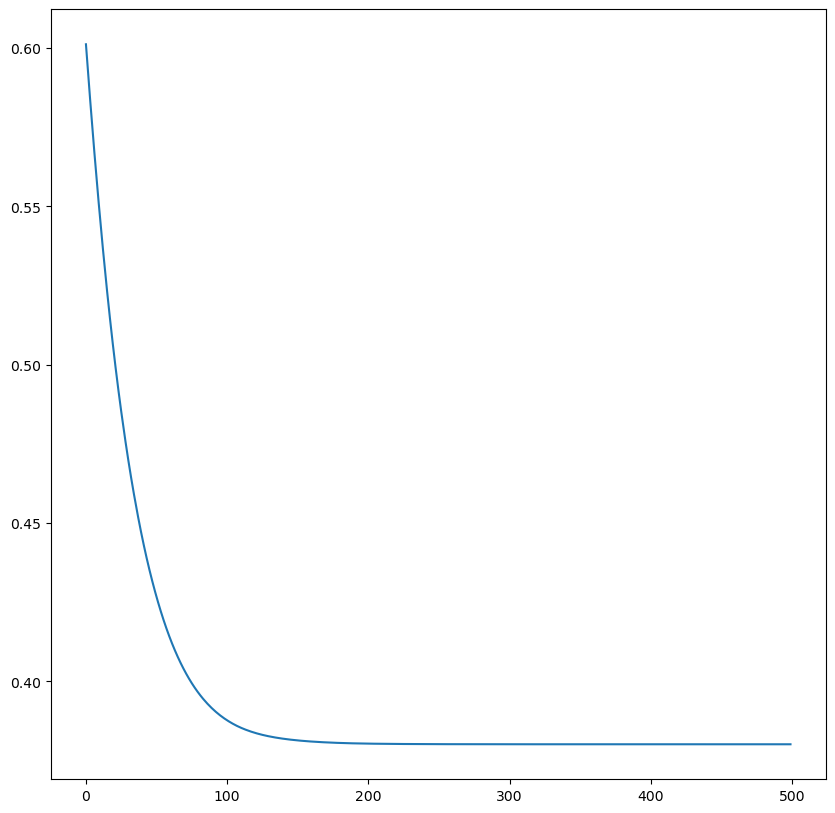

In [6]:
EPOCHS= 500
x_p , y_p = comp_node(val =0.9) , comp_node(val =0.8)

DELTA = 0.01
# H=0.01
epoch_losses = []
for _ in range(EPOCHS):
    curr_loss = loss_graph(x_p , y_p , data_x,data_y)
    curr_loss.backward()
    epoch_losses.append(curr_loss.val)
    x_p -= DELTA* x_p.grad 
    y_p -= DELTA* y_p.grad 
fig = figure(figsize = (10,10))
ax= fig.add_subplot(1,1,1)
ax.plot(epoch_losses)
fig.show()

In [7]:
print(x_p)

op: sub | val: 0.4833 | children: 2 | grad: 0


In [8]:
print(y_p)

op: sub | val: 0.4906 | children: 2 | grad: 0


In [9]:
loss_graph(x_p , y_p , data_x , data_y)

op: mul | val: 0.3801 | children: 2 | grad: 0

second example will be the equation of line mx+c 

In [3]:
from random import Random
SEED = 5
random_gen = Random(x =SEED)
slope = 3
intersect = 2

def generate_points(n = 1000):
    x,y= [] , []
    for i in range(n):
        x.append(random_gen.uniform(a=2,b=5))
    for i in range(n):
        y.append((slope*x[i]+intersect))
    return x,y

data_x , data_y = generate_points()


C:\Windows\Temp\ipykernel_10852\52880289.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


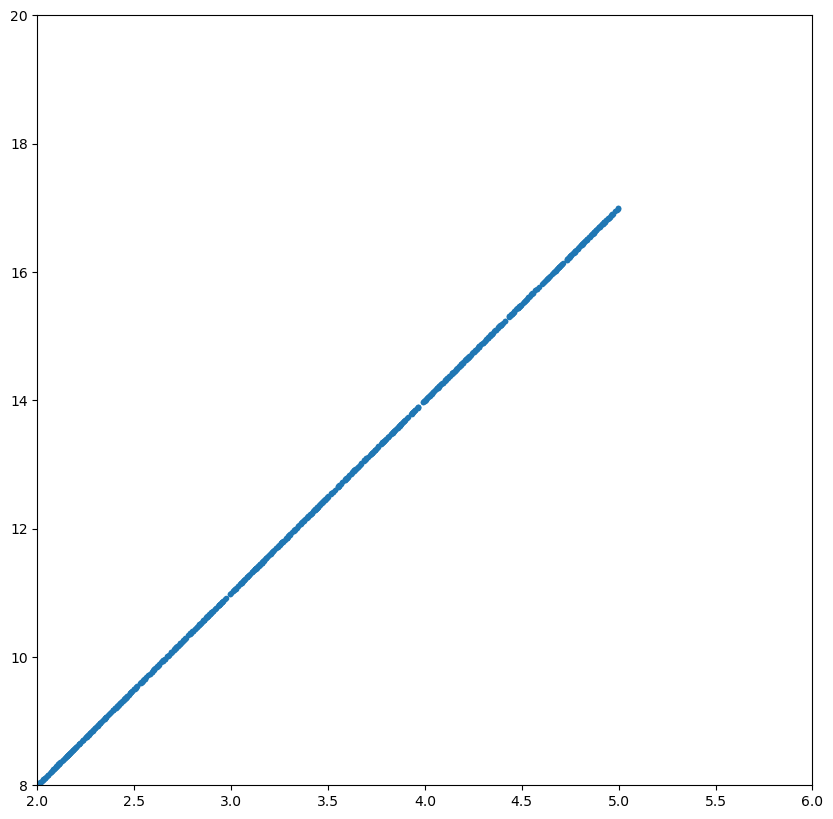

In [4]:
from matplotlib.pyplot import figure
fig = figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x = data_x,y = data_y, marker = ".")
ax.set_xlim(2 , 6)
ax.set_ylim(8 , 20)
fig.show()

In [5]:
def loss_graph(m, c , data_x, data_y):
    loss = 0 
    for x , y in zip(data_x , data_y):
        I_x = m* x 
        y_hat = I_x + c
        M = y_hat - y
        l = M ** (2)
        loss+= l
    return (1/len(data_x))* loss



C:\Windows\Temp\ipykernel_10852\1777472767.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


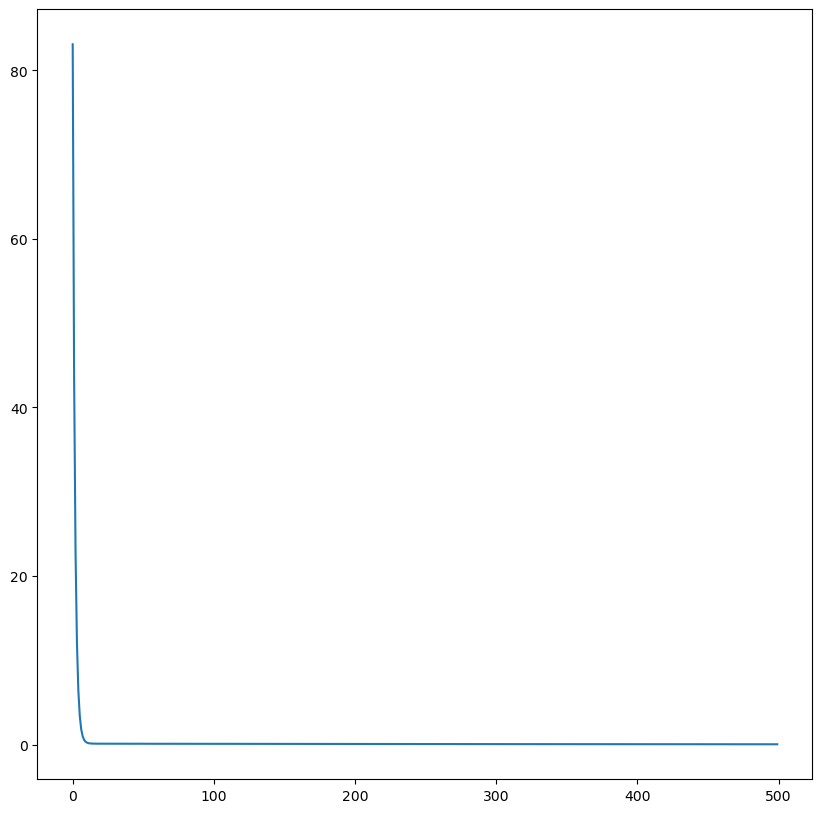

In [6]:
EPOCHS = 500
m_calc , c_calc = comp_node(val = 5) , comp_node(val = 4)
H= 0.01
DELTA = 0.01
epochs_losses = []
dloss_dm , dloss_dc = None , None
for _ in range(EPOCHS):
    curr_loss = loss_graph(m_calc, c_calc , data_x,data_y)
    curr_loss.backward()
    epochs_losses.append(curr_loss.val)
    m_calc -= DELTA*m_calc.grad
    c_calc -= DELTA*c_calc.grad

fig = figure(figsize = (10,10))
ax= fig.add_subplot(1,1,1)
ax.plot(epochs_losses)
fig.show()

In [7]:
print(m_calc)
print(c_calc)

op: sub | val: 2.7885 | children: 2 | grad: 0
op: sub | val: 2.7778 | children: 2 | grad: 0


In [8]:
loss_graph(m_calc, c_calc , data_x,data_y)

op: mul | val: 0.0361 | children: 2 | grad: 0